In [25]:
import numpy as np
from pylab import *
       
%matplotlib notebook

from craco import calibration
%load_ext autoreload
%autoreload 2
from scipy.interpolate import interp1d
from craft.uvfits import UvFits,bl2ant
from craft.craco import bl2array
from craco.cardcap import get_indexes

from astropy.io import fits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
uf = fits.open('/data/seren-01/big/craco/SB048933/scans/00/20230319103905/results/b00.uvfits')
f = UvFits(uf)
f.ignore_autos = False

In [17]:
blk = next(f.time_blocks(256))

In [113]:
len(blk)

465

In [114]:
blka = bl2array(blk)[:,:,0,:]

In [115]:
blka.shape

(465, 168, 256)

In [116]:
blka.dtype

dtype('complex64')

In [117]:
nant = 30
(products, revproducts, auto_products, cross_products) = get_indexes(nant)


In [119]:
autos = blka[auto_products,:,:].real
autos.shape

(30, 168, 256)

In [194]:
np.where(autos<0)

(array([21, 21, 26]), array([81, 81, 81]), array([ 61, 213, 218]))

<IPython.core.display.Javascript object>


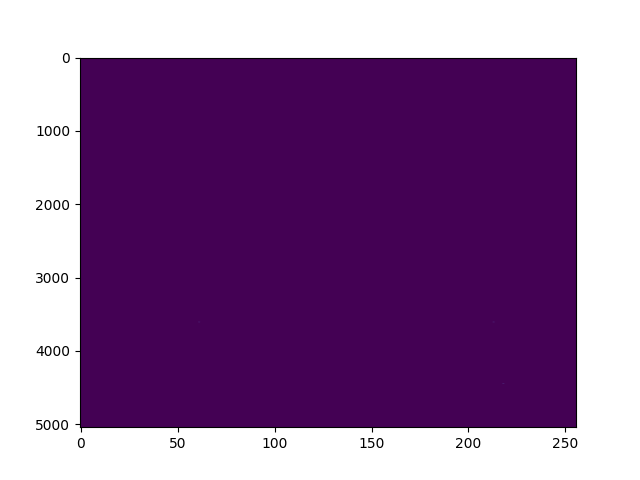

In [193]:
figure()
imshow(autos.reshape(30*168,-1)<0, aspect='auto')

<IPython.core.display.Javascript object>


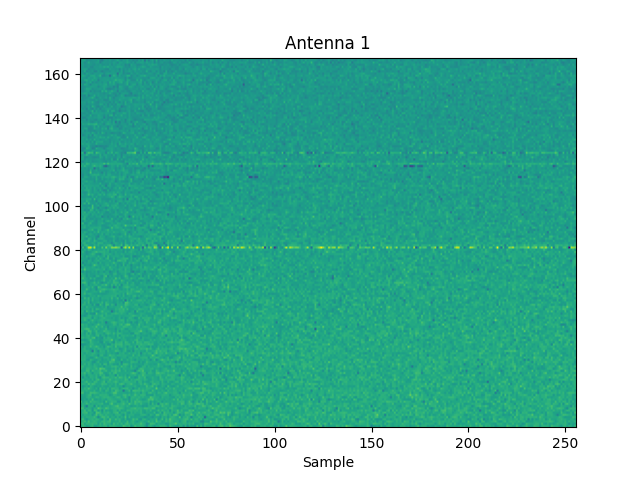

Text(0.5, 1.0, 'Antenna 1')

In [170]:
figure()
imshow(autos[0,:,:], origin='lower', aspect='auto')
xlabel('Sample')
ylabel('Channel')
title('Antenna 1')

In [171]:
def mynorma(d,axis=2):
    # Z score normalise input data long given (usually time axis)
    return (d - abs(d).mean(axis=axis, keepdims=True))/abs(d).std(axis=axis, keepdims=True)

In [173]:
def dmroll(d,dm = 69):
    '''
    DM roll channels to given DM
    '''
    dout = np.empty_like(d)
    freqs = f.channel_frequencies/1e9
    nf, nt = d.shape
    assert nf == len(freqs)
    fch1 = freqs[0]
    for chan in range(nf):
        fchan = freqs[chan]
        delay_ms = -4.15*dm*(fchan**-2 - fch1**-2)
        delay_samp = int(np.round(delay_ms/1.7))
        dout[chan,:] = np.roll(d[chan,:], delay_samp)
        
    return dout

In [174]:
ddvis = np.empty_like(blka)
for ic in range(blka.shape[0]):
    ddvis[ic, ...] = dmroll(blka[ic, ...])

In [175]:
ics = mynorma(ddvis[auto_products,...].real).mean(axis=0)

<IPython.core.display.Javascript object>


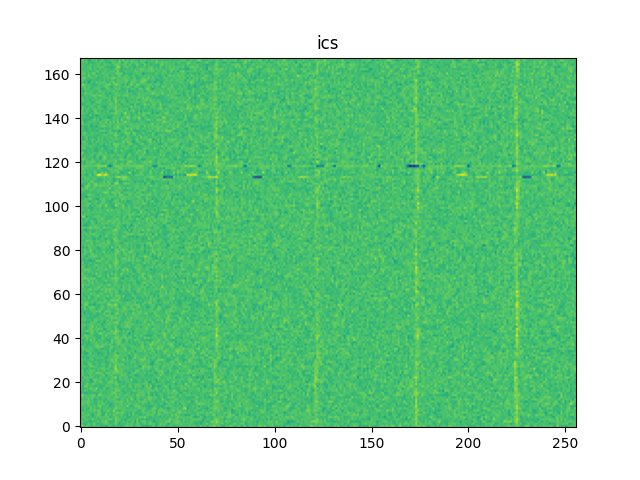

Text(0.5, 1.0, 'ics')

In [176]:
figure()
imshow(ics, origin='lower', aspect='auto')
title('ics')

<IPython.core.display.Javascript object>


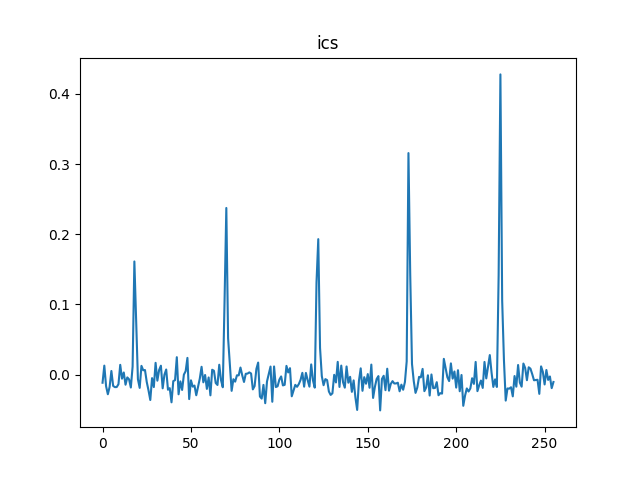

Text(0.5, 1.0, 'ics')

In [178]:
figure()
plot(ics.mean(axis=0))
title('ics')

In [180]:
cas = mynorma(abs(ddvis[cross_products,...])).mean(axis=0)
cas.shape

(168, 256)

<IPython.core.display.Javascript object>


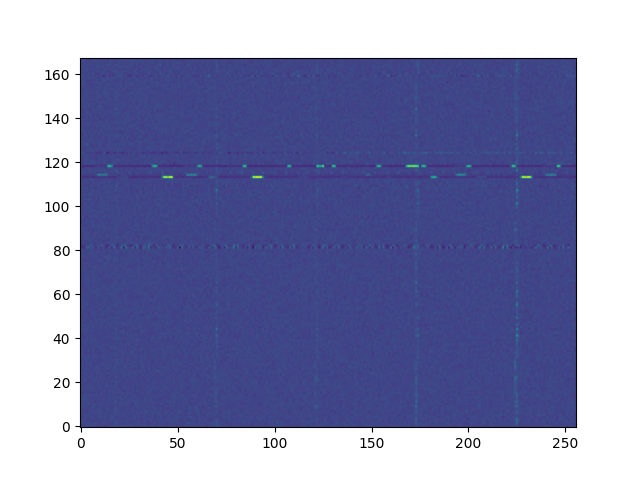

In [181]:
figure()
imshow(cas, aspect='auto', origin='lower')

<IPython.core.display.Javascript object>


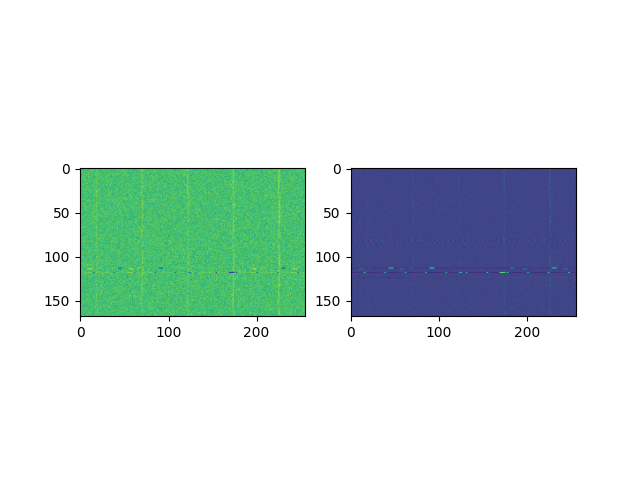

In [182]:
fig,ax = subplots(1,2)
ax[0].imshow(ics)
ax[1].imshow(cas)
                  

In [186]:
ddvis.shape

(465, 168, 256)

In [187]:
ddvis[cross_products,...].shape

(435, 168, 256)

In [188]:
# ICS = take autos, real part, normalise antennas, take mean over antennas and channel
icst = mynorma(ddvis[auto_products,...].real).mean(axis=(0,1))

# CAS then DD - cross terms, amplitude, norrmalise baseline over time, then mean over baseline and channel
casddt = mynorma(abs(ddvis[cross_products,...])).mean(axis=(0,1))

# DD then cas - cross terms, *complex* average over frequency, take magnitude, absolute value, noramlise over time, then average over baselines
ddcast = mynorma(abs(ddvis[cross_products,...].mean(axis=1)),axis=1).mean(axis=0)

<IPython.core.display.Javascript object>


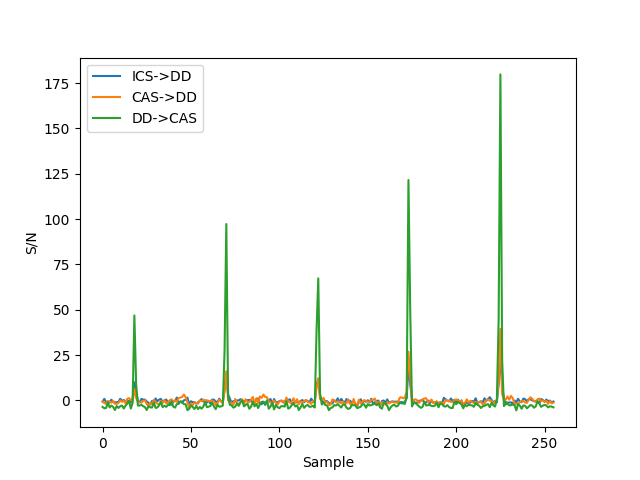

In [189]:
figure()
x = slice(130,165) # normalise by noise in a signal-free window
plot(icst/icst[x].std(), label='ICS->DD')
plot(casddt/casddt[x].std(), label='CAS->DD')
plot(ddcast/ddcast[x].std(), label='DD->CAS')
xlabel('Sample')
ylabel('S/N')

legend()